# Usage Efficiency of Bike Sharing System

## Investigation Overview  

In this investigation, I want to know when are most trips taken in terms of time of day, day of the week, and what kind of people takes the most trip in this time. "start_time" is the main features, and the renter feature such as member_gender, member_birth_year, user_type are also investigated.

## Dataset Overview

There are 183,412 rows in the dataset with 15 features, five features are numeric in nature(duration_sec, start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude), yet there are 197 NaN in station id and station name, and 8265 NaN in member_birth_year and member gender.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# adjust the erroneous datatypes
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df.start_station_id = df.start_station_id.astype('str').str[:-2]
df.start_station_id = df.start_station_id.replace('n', np.nan)
df.end_station_id = df.end_station_id.astype('str').str[:-2]
df.end_station_id = df.end_station_id.replace('n', np.nan)
df.bike_id = df.bike_id.astype('str')
df.user_type = df.user_type.astype('category')
df.member_gender = df.member_gender.astype('category')
df.bike_share_for_all_trip = df.bike_share_for_all_trip.astype('category')

## Distribution of start_time grouped by day

The rental count have regular ups and downs through whole February with most data on weekday (blue bar), the few on weekend (red bar). With the plot, which divide February into the days of the week, the difference between weekday and weekend can be clearly seen.

> Noted: There is relatively low amount on February 13, 2019, and I take a deep look. I find that there was a heavy rain on February 13, 2019 in San Francisco, here is [link](https://www.kron4.com/news/san-francisco-sees-flooded-roadways-during-storm/).

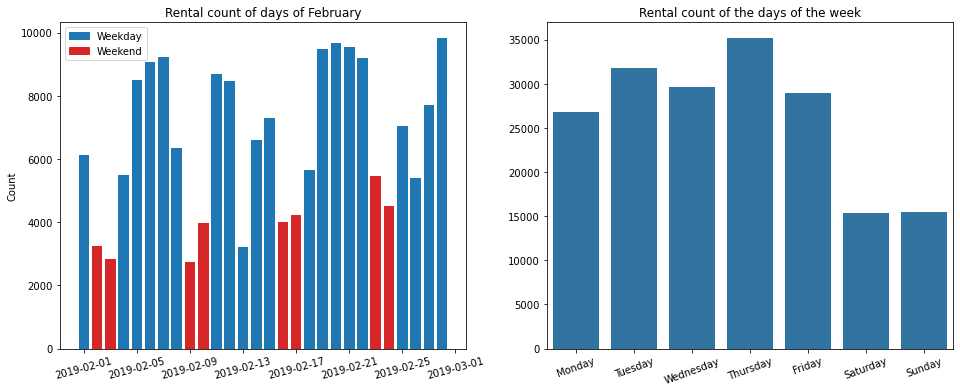

In [4]:
# extract the year, month, day from start_time
first_time = df.start_time.min().strftime('%Y-%m-%d')
last_time = df.start_time.max().strftime('%Y-%m-%d')
# make a time index
time_bin = pd.date_range(first_time, last_time, freq='D')
workday = pd.date_range(first_time, last_time, freq='B')

# make weekday and weekend have different color
colors = []
for value in time_bin: 
    if value in workday:
        colors.append(sb.color_palette()[0])
    else:
        colors.append(sb.color_palette()[3])

# bar plot of start_time separated by day
plt.figure(figsize=[16,6])
plt.subplot(1,2,1)
num_day = df.groupby(df.start_time.map(lambda x: x.day)).duration_sec.count()
plt.bar(time_bin, num_day, color=colors)
plt.xticks(rotation=15);
plt.title('Rental count of days of February')
plt.ylabel('Count')
# make the legend
Handles = [plt.Rectangle((0,0),1,1, color=sb.color_palette()[0]), plt.Rectangle((0,0),1,1, color=sb.color_palette()[3])]
labels = ['Weekday','Weekend']
plt.legend(Handles, labels, loc=2)

plt.subplot(1,2,2)
# make a new column "day"
df['day'] = df.start_time.dt.day_name()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
default_color = sb.color_palette()[0]
sb.countplot(data=df, x='day', color=default_color, order=days)
plt.title('Rental count of the days of the week')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=20);

## Distribution of start_time grouped by hour
Take a deeper look about time, when 7am-9am and 4pm-6pm, there are a lot of bikes be rented. And when at 8pm, the rental count have been decreased until 5am. And 7am-9am, 4pm-6pm are just the rush hour in San Francisco.

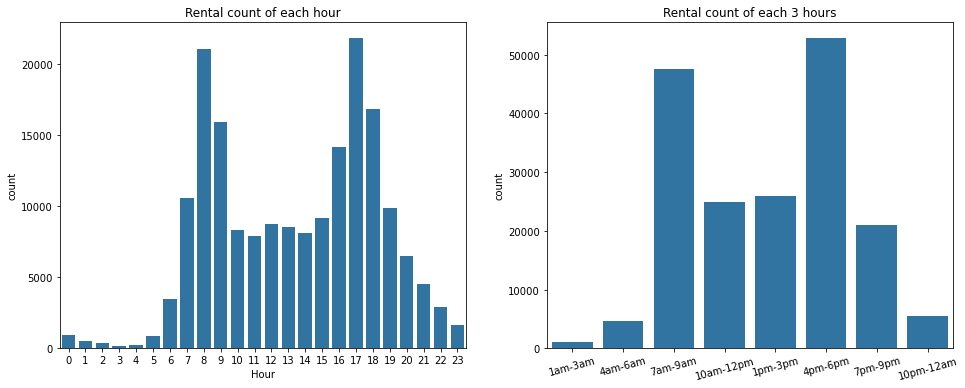

In [5]:
# make a column extract the hour from start_time
df['hour'] = df['start_time'].dt.hour
plt.figure(figsize=[16,6])
plt.subplot(1,2,1)
# countplot of hour
sb.countplot(data=df, x='hour', color=default_color)
plt.title('Rental count of each hour')
plt.xlabel('Hour')

plt.subplot(1,2,2)
time_section = []
for x in df.hour:
    if (x >= 1 and x <=3):
        time_section.append('1am-3am')
    elif (x >= 4 and x <=6):
        time_section.append('4am-6am')
    elif (x >= 7 and x <=9):
        time_section.append('7am-9am')
    elif (x >= 10 and x <=12):
        time_section.append('10am-12pm')
    elif (x >= 13 and x <=15):
        time_section.append('1pm-3pm')
    elif (x >= 16 and x <= 18):
        time_section.append('4pm-6pm')
    elif (x >= 19 and x <=21):
        time_section.append('7pm-9pm')
    else: 
        time_section.append('10pm-12am')
df['time_section'] = time_section
time_sec = ['1am-3am', '4am-6am', '7am-9am', '10am-12pm', '1pm-3pm', '4pm-6pm', '7pm-9pm', '10pm-12am']
# countplot of time section
sb.countplot(data=df, x='time_section', color=default_color, order=time_sec)
plt.xticks(rotation=15)
plt.title('Rental count of each 3 hours')
plt.xlabel('');

## Rental count and time and gender

Among all renters, 74.6% are male and 23.3% are female, and there is no big difference with the gender composition of rush hour.

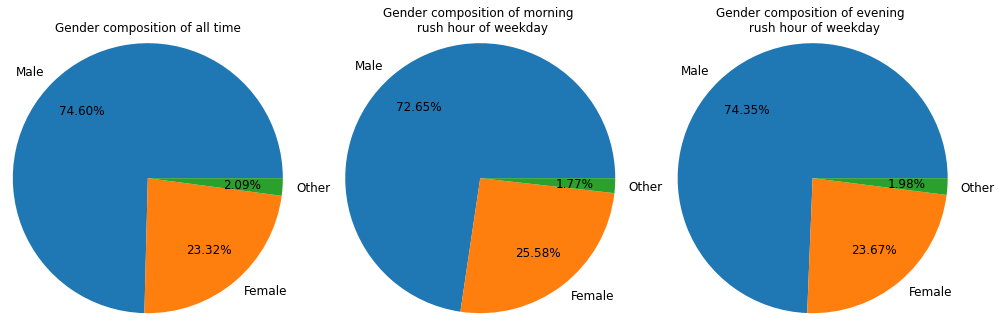

In [18]:
plt.figure(figsize=[14,6])
plt.subplot(1,3,1)
plt.pie(df.member_gender.value_counts(), labels =df.member_gender.value_counts().index, 
        autopct='%.2f%%', radius=1.2, pctdistance=0.7, textprops={'fontsize': 12})
plt.title('Gender composition of all time' )

plt.subplot(1,3,2)
df_morning = df[(df['time_section'] == '7am-9am') & (df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))]
plt.pie(df_morning.member_gender.value_counts(), labels =df_morning.member_gender.value_counts().index, 
        autopct='%.2f%%', radius=1.2, pctdistance=0.7, textprops={'fontsize': 12});
plt.title('Gender composition of morning \n rush hour of weekday')

plt.subplot(1,3,3)
df_evening = df[(df['time_section'] == '4pm-6pm') & (df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))]
plt.pie(df_evening.member_gender.value_counts(), labels =df_evening.member_gender.value_counts().index, 
        autopct='%.2f%%', radius=1.2, pctdistance=0.7, textprops={'fontsize': 12})
plt.title('Gender composition of evening \n rush hour of weekday')
plt.tight_layout();

## Rental count and time and user type

Among all renters, 89.2% are subscribers. There are 92.2% and 90.4% in morning and evening rush hour only with little increasing. Overall, the trend is similar.

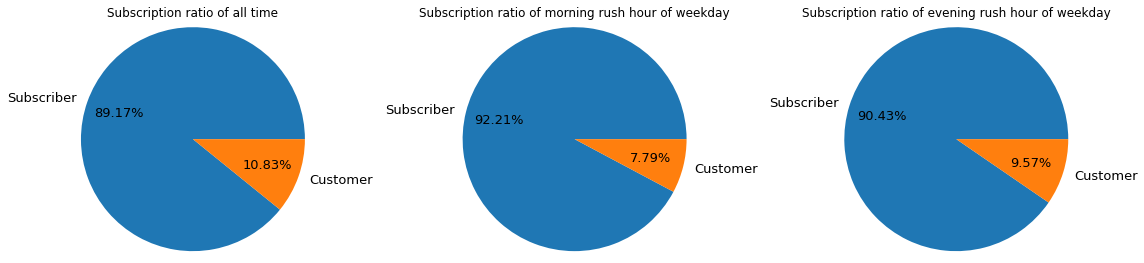

In [19]:
plt.figure(figsize=[16,8])
plt.subplot(1,3,1)
plt.pie(df.user_type.value_counts(), labels =df.user_type.value_counts().index, 
        autopct='%.2f%%', radius=1.2, pctdistance=0.7, textprops={'fontsize': 13})
plt.title('Subscription ratio of all time' )

plt.subplot(1,3,2)
plt.pie(df_morning.user_type.value_counts(), labels =df_morning.user_type.value_counts().index, 
        autopct='%.2f%%', radius=1.2, pctdistance=0.7, textprops={'fontsize': 13})
plt.title('Subscription ratio of morning rush hour of weekday')

plt.subplot(1,3,3)
plt.pie(df_evening.user_type.value_counts(), labels =df_evening.user_type.value_counts().index, 
        autopct='%.2f%%', radius=1.2, pctdistance=0.7, textprops={'fontsize': 13})
plt.title('Subscription ratio of evening rush hour of weekday')
plt.tight_layout();

## Rental count and time and age

Among all renters, most of their age aggregate between 1980 to 2000, and same trend are found in rush hours.

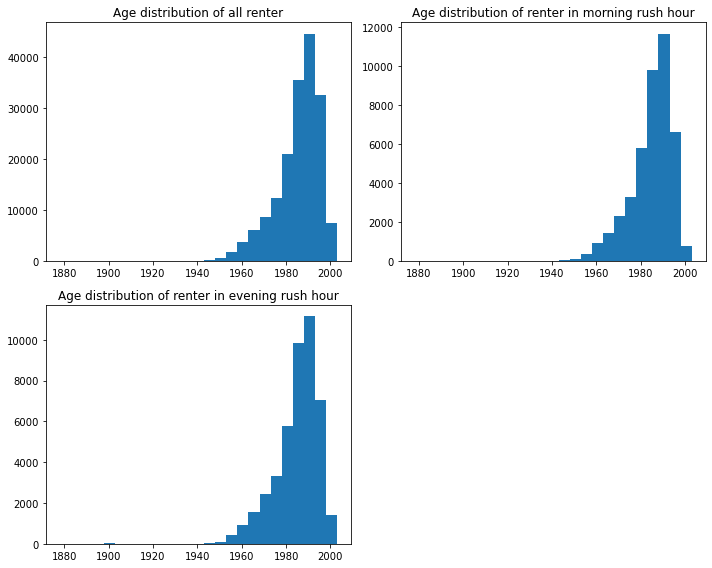

In [8]:
plt.figure(figsize=[10,8])
plt.subplot(2,2,1)
bins = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+5, 5)
plt.hist(data=df, x='member_birth_year', bins=bins)
plt.title('Age distribution of all renter' )

plt.subplot(2,2,2)
bins = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+5, 5)
plt.hist(data=df_morning, x='member_birth_year', bins=bins)
plt.title('Age distribution of renter in morning rush hour' )

plt.subplot(2,2,3)
bins = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+5, 5)
plt.hist(data=df_evening, x='member_birth_year', bins=bins)
plt.title('Age distribution of renter in evening rush hour' )

plt.tight_layout();

In conclusion, we find out the renters who are most possible to take a ride when most trips happened. It consist mainly of male subscribers who born between 1980 to 2000. 

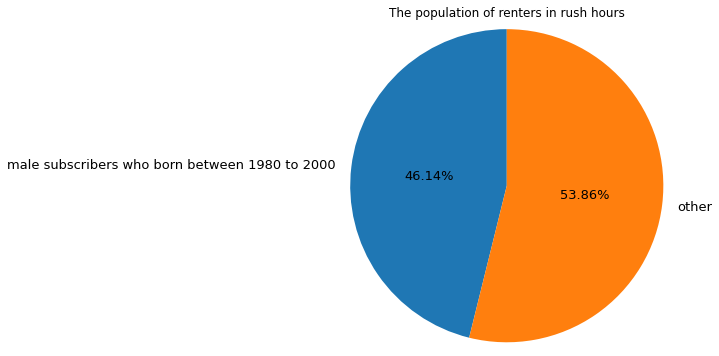

In [15]:
df_est = df[(df['time_section'].isin(['7am-9am', '4pm-6pm'])) & (df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) 
            & (df['member_gender'] == 'Male') & (df['user_type'] == 'Subscriber') & (df['member_birth_year'] > 1980) & (df['member_birth_year'] < 2000)]
df_other = df[(df['time_section'].isin(['7am-9am', '4pm-6pm'])) & (df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))]
plt.figure(figsize=[6,6])
labels = ['male subscribers who born between 1980 to 2000', 'other']
sizes = [df_est.shape[0], df_other.shape[0]-df_est.shape[0]]
plt.pie(sizes, labels=labels, autopct='%.2f%%', radius=1.2, pctdistance=0.5, startangle=90, textprops={'fontsize': 13})
plt.title('The population of renters in rush hours');